### Import libraries

In [1]:
import numpy as np
import pandas as pd
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

### Train Data & Test Data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('Self_testData.csv')

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Parik\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Parik\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Parik\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Parik\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Parik\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

### Text cleaning and pre-processing

In [4]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# pre-processing of text in 1 single function
def preprocess_text(text):
    # remove links from text - https
    non_http_list = [w for w in text.lower().split() if 'http' not in w]
    
    # remove @ words from tweets
    at_removed_list = [w for w in non_http_list if '@' not in w]
    
    # tokenize sentences to words
    words = word_tokenize(' '.join(at_removed_list))
    
    # remove punctuation
    word_list = [w for w in words if w not in string.punctuation]
    
    # remove stop words
    tokens = [w for w in word_list if w not in stop_words]
    
    # stemming
    stemmed = [porter.stem(w) for w in tokens]
    
    # lemmatization
    lemmatized = " ".join([lemmatizer.lemmatize(w) for w in tokens])
    
    return lemmatized

In [5]:
# preprocess and cleaned text, later stored in a new column named 'transformed_text'
df_train['transformed_text'] = df_train['text'].apply(lambda text: preprocess_text(text))
df_test['transformed_text'] = df_test['text'].apply(lambda text: preprocess_text(text))

### Exploratory Data Analysis

Reference used: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [6]:
# removing NaN values
df_train['keyword'].fillna('', inplace=True)
df_test['keyword'].fillna('', inplace=True)

#### Pie chart, to display class distribution in training data

There doesn't appear to be a significant difference in the number of disaster and non-disaster tweets in the training dataset. The proportion of each type is fairly similar.

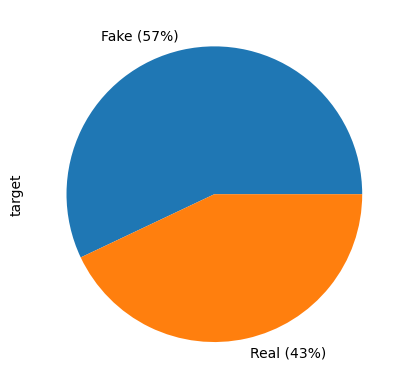

In [7]:
pos_no = round((df_train['target'].value_counts()/df_train['target'].value_counts().sum())*100)

df_train['target'].value_counts().plot(kind='pie', labels=['Fake ('+str(int(pos_no[0]))+'%)', 'Real ('+str(int(pos_no[1]))+'%)'])
plt.savefig('target_distribution_pie.png')

#### Keyword and class distribution

We have observed that certain keywords are strongly associated with disaster tweets while others are more often found in non-disaster tweets. However, some keywords that are predominantly associated with non-disaster tweets are still relevant to disaster reporting. Therefore, relying solely on keywords to learn the distribution of classes may not be effective.

In [8]:
import seaborn as sns

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

plt.figure(figsize=(16, 72), dpi=300)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'], 
    hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.savefig('keyword_class.png')
# plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

#### Bigram analysis

Although disaster-related tweets may contain words that are typically associated with disasters, this is not always the case. In fact, many commonly occurring bigrams in disaster tweets do not actually relate to disasters. Additionally, non-disaster tweets may also contain bigrams that could potentially relate to a disaster, such as "burning building" or "emergency services". Therefore, a rule-based system or simply relying on the presence of certain words would not be an effective approach for accurately identifying disaster-related tweets, and such an approach would not be scalable.

C:\Users\Parik\AppData\Local\Temp\ipykernel_1344\4081449788.py:41: UserWarning: Glyph 137 (\x89) missing from current font.
  plt.savefig('bigram_analysis.png')
C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


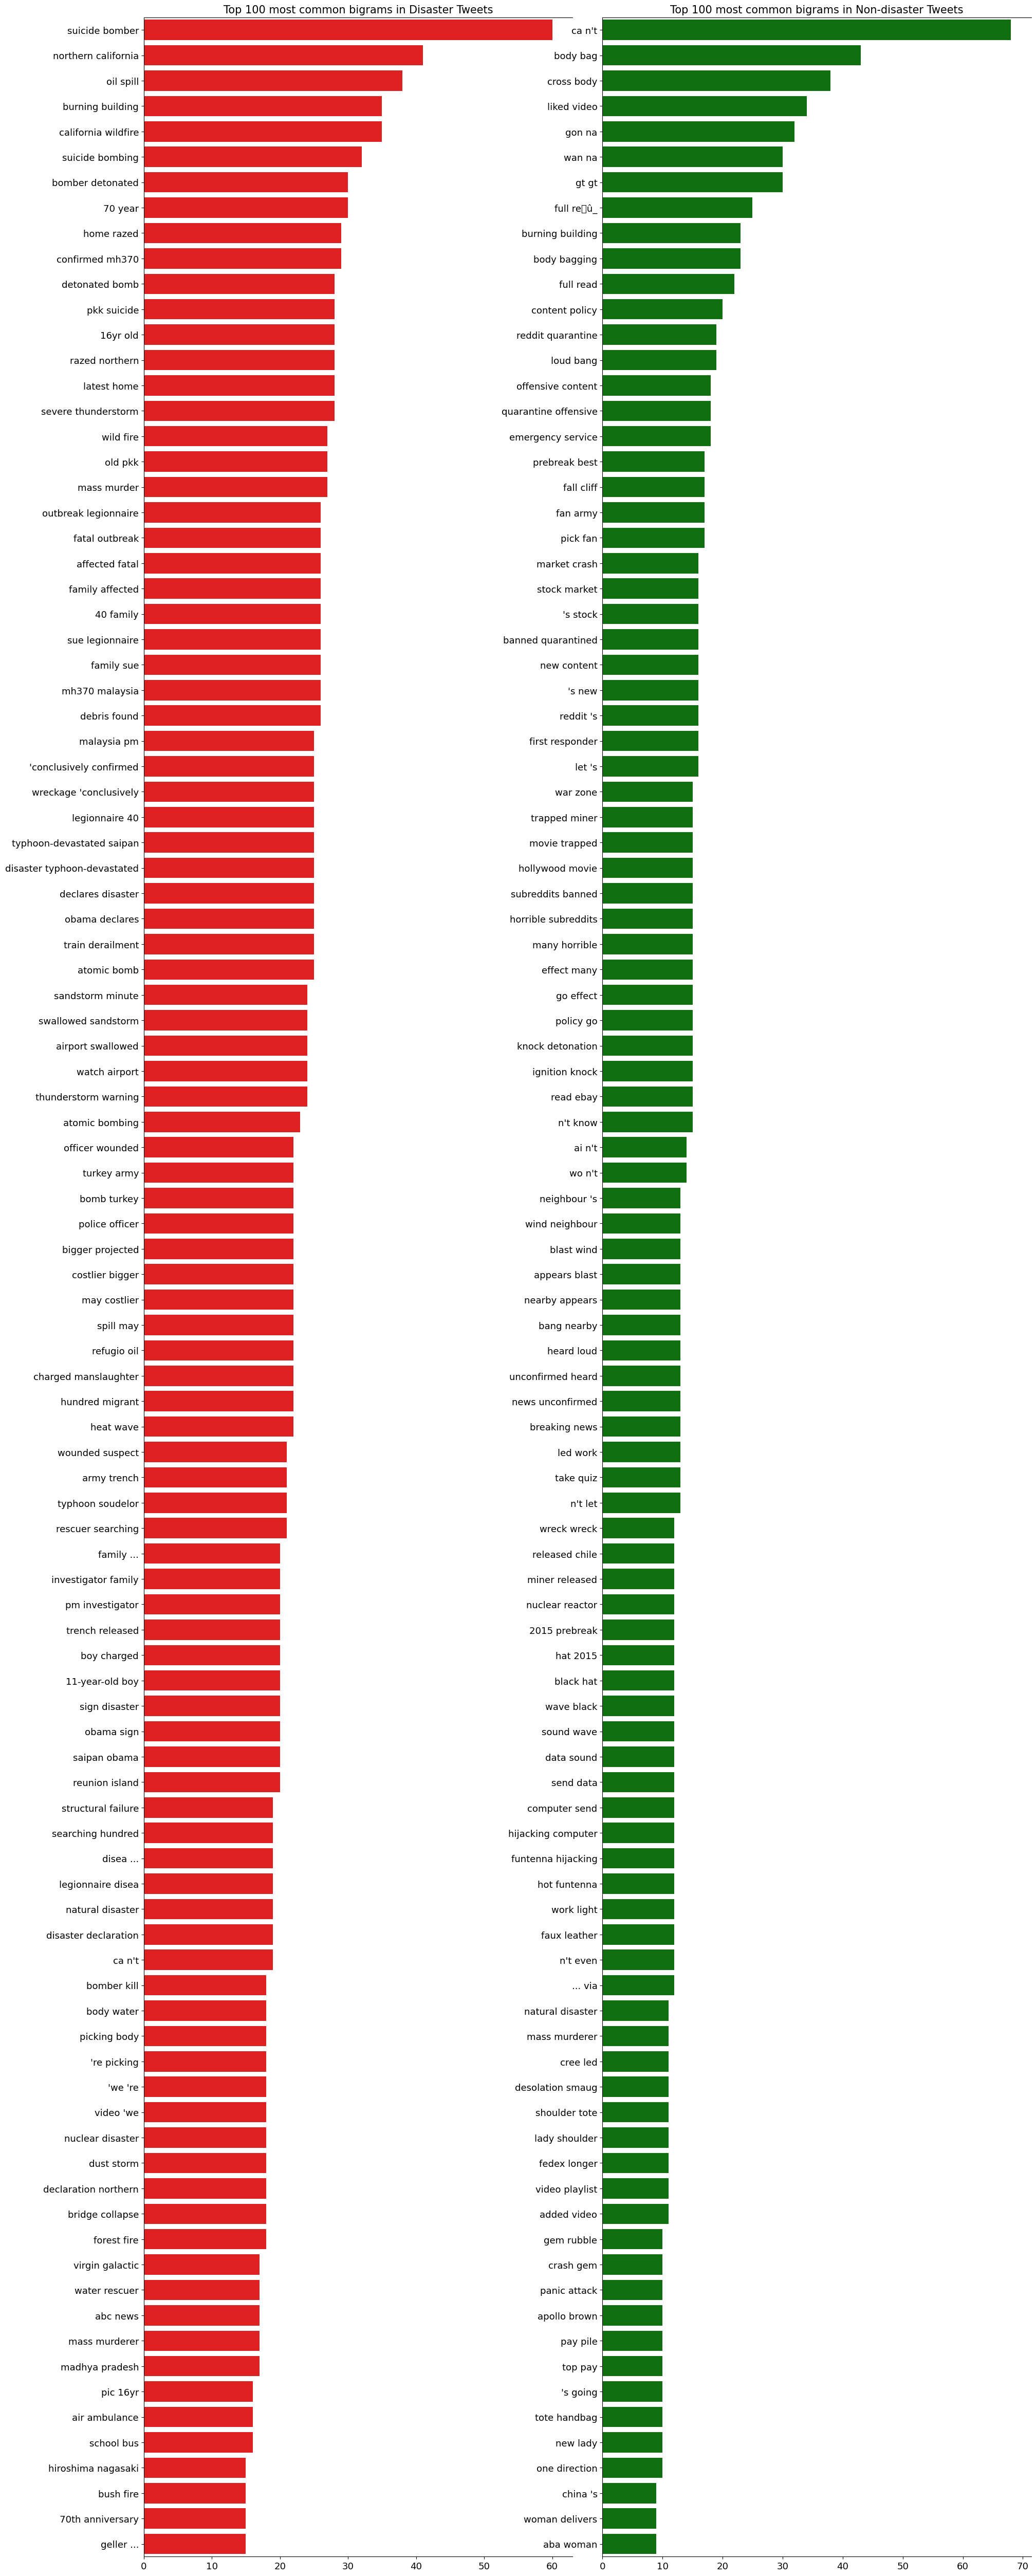

In [9]:
import seaborn as sns
from collections import defaultdict

def ngrams_generate(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

bigrams_disaster = defaultdict(int)
nonbigrams_disaster = defaultdict(int)

for tweet in df_train[df_train['target']==1]['transformed_text']:
    for word in ngrams_generate(tweet, n_gram=2):
        bigrams_disaster[word] += 1
        
for tweet in df_train[df_train['target']==0]['transformed_text']:
    for word in ngrams_generate(tweet, n_gram=2):
        nonbigrams_disaster[word] += 1
        
df_bigrams_disaster = pd.DataFrame(sorted(bigrams_disaster.items(), key=lambda x: x[1])[::-1])
df_nonbigrams_disaster = pd.DataFrame(sorted(nonbigrams_disaster.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_bigrams_disaster[0].values[:N], x=df_bigrams_disaster[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nonbigrams_disaster[0].values[:N], x=df_nonbigrams_disaster[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.savefig('bigram_analysis.png')
plt.show()

#### Percentage of missing values for locations

In [10]:
# training -
train_missing_data = df_train.location.isnull().sum()
train_present_data = df_train.location.value_counts().sum()

print('Missing values in train: %d'%train_missing_data)
print('Present values in train: %d'%train_present_data)

#testing -
test_missing_data = df_test.location.isnull().sum()
test_present_data = df_test.location.value_counts().sum()

print('Missing values in test: %d'%test_missing_data)
print('Present values in test: %d'%test_present_data)

Missing values in train: 2533
Present values in train: 5080
Missing values in test: 1105
Present values in test: 2158


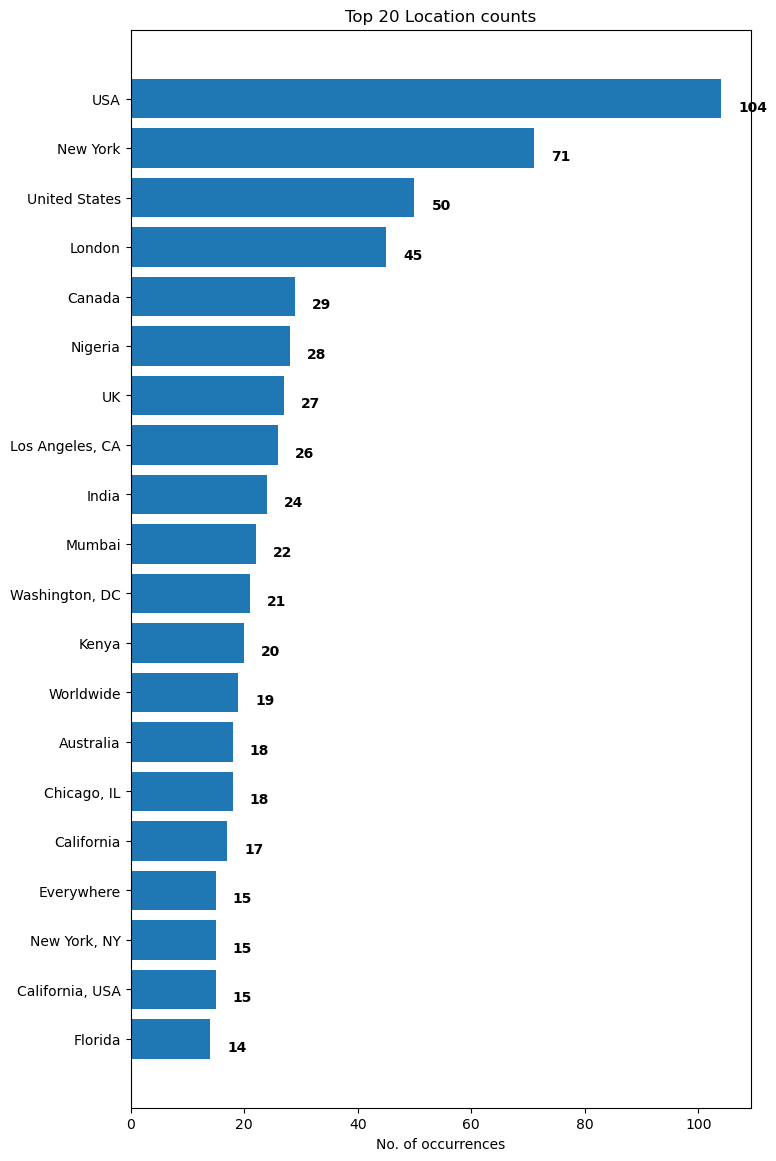

In [11]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(8,14)

x = df_train.location.value_counts().index.tolist()[:20]
y = df_train.location.value_counts().tolist()[:20]

y_pos = np.arange(len(x))
ax.barh(y_pos, y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('No. of occurrences')
ax.set_title('Top 20 Location counts')

for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), fontweight='bold')

plt.savefig('location_discrete.png')
plt.show()

#### Finding keywords frequency for top 10 locations

In [12]:
x = df_train.location.value_counts().index.tolist()[:25]
y = df_train.location.value_counts().tolist()[:25]

missing = df_train.location.isnull().sum()
present = df_train.location.value_counts().sum()

top_10_keywords = df_train.keyword.value_counts().index.tolist()[:10]
top_10_locations = df_train.location.value_counts().index.tolist()[:10]

print('keywords:')
print(top_10_keywords)
print('locations:')
print(top_10_locations)

keywords:
['', 'fatalities', 'deluge', 'armageddon', 'sinking', 'damage', 'harm', 'body%20bags', 'evacuate', 'fear']
locations:
['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria', 'UK', 'Los Angeles, CA', 'India', 'Mumbai']


In [13]:
all_locations = []
true_df = df_train[df_train['target']==1]
for loc in top_10_locations:
    filter_df = true_df[true_df['location'] == loc]
    all_locations.append(filter_df['keyword'].value_counts().index[0])

print(all_locations)
print('\n\n')
dict(zip(top_10_locations, all_locations)) 

['sandstorm', 'flood', 'hazardous', 'annihilated', 'airplane%20accident', 'suicide%20bomb', 'accident', 'oil%20spill', 'derailment', 'wreckage']





{'USA': 'sandstorm',
 'New York': 'flood',
 'United States': 'hazardous',
 'London': 'annihilated',
 'Canada': 'airplane%20accident',
 'Nigeria': 'suicide%20bomb',
 'UK': 'accident',
 'Los Angeles, CA': 'oil%20spill',
 'India': 'derailment',
 'Mumbai': 'wreckage'}

### countvectortorizer -  without using Keyword column

In [14]:
# build bag of words model
countvector = feature_extraction.text.CountVectorizer()

# transform train, test data
train_vector = countvector.fit_transform(df_train['transformed_text'])
test_vector = countvector.transform(df_test['transformed_text'])

In [15]:
train_vector.toarray()[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF-IDF vectorizer - without using keyword column

In [16]:
# build bag of words model
tfidfvector = feature_extraction.text.TfidfVectorizer()

# transform train, test data
train_vector = tfidfvector.fit_transform(df_train['transformed_text'])
test_vector = tfidfvector.transform(df_test['transformed_text'])

In [17]:
train_vector.shape

(7613, 13614)

### monte-carlo simulation for different classifiers

In [18]:
from sklearn.metrics import f1_score

def fit_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return f1_score(y_test, y_pred)

models = [LogisticRegression(), LinearSVC(), MultinomialNB(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), RandomForestClassifier()]
score_list = []
for model in models:
    score_list.append([])

loop = 5
for index in range(loop):
    x_train, x_test, y_train, y_test = train_test_split(train_vector, df_train['target'], test_size=0.2, shuffle=True, stratify=df_train['target'])
    for (i,model) in enumerate(models):
        score_list[i].append(fit_predict(model, x_train, y_train, x_test, y_test))

scores_final = np.array(score_list).mean(axis=1)
d = {'Classifier': ['Logistic Regression', 'Linear SVM', 'Multinomial Naive Bayes', 'Decision Tree', 'KNN', 'Random Forest'], 'Mean F-1 scores': scores_final}
models_f1_final = pd.DataFrame(d)
models_f1_final.to_csv('all_model_results.csv', index=False)
models_f1_final

,Classifier,Mean F-1 scores
0,Logistic Regression,0.727141
1,Linear SVM,0.729887
2,Multinomial Naive Bayes,0.738845
3,Decision Tree,0.692027
4,KNN,0.686731
5,Random Forest,0.720431


###### The performance of the top four classifiers is similar, so we will perform hyper-parameter tuning on all of them.

### Hyper-parameter tuning for Logistic Regression

In [19]:
# define classifiers
logistic_reg = LogisticRegression(max_iter=10000)
parameters = {'C':[0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
clf = GridSearchCV(logistic_reg, parameters, cv=10, scoring='f1')

# fit classifier to training data
clf.fit(train_vector, df_train['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

# predict labels for test data
predictions = clf.predict(test_vector)
df_test['target'] = predictions

Best score: 0.560706

Best params: {'C': 10, 'solver': 'liblinear'}


### Hyper-parameter tuning for Linear SVM

In [20]:
# define classifiers
# clf = linear_model.RidgeClassifier()
# clf = LogisticRegression(solver='lbfgs')
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc = LinearSVC(max_iter=10000)
clf = GridSearchCV(svc, parameters, cv=10)

# fit classifier to training data
clf.fit(train_vector, df_train['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Li

Best score: 0.693417

Best params: {'C': 0.1}


C:\Users\Parik\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Hyper-parameter tuning for Multinomial Naive Bayes

In [21]:
parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
mnb = MultinomialNB()
clf = GridSearchCV(mnb, parameters, cv=10)

# fit classifier to training data
clf.fit(train_vector, df_train['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

predictions = clf.predict(test_vector)
df_test['target'] = predictions

# generate submission csv file
df_test[['id','target']].to_csv('submission.csv',index=False)

Best score: 0.701567

Best params: {'alpha': 1}


### Hyper-parameter tuning for Decision Tree

In [22]:
parameters = {'criterion': ['gini', 'entropy']}
mnb = DecisionTreeClassifier()
clf = GridSearchCV(mnb, parameters, cv=10)

# fit classifier to training data
clf.fit(train_vector, df_train['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

Best score: 0.530929

Best params: {'criterion': 'entropy'}
